In [2]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

dataset, info = tfds.load('oxford_iiit_pet', with_info=True)


2025-07-07 23:21:58.252663: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-07 23:21:58.254294: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-07 23:21:58.370273: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-07 23:21:58.790108: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-07 23:21:59.944789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [3]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32)/255.0
    input_mask -= 1
    return input_image, input_mask

In [4]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128,128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [4]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128,128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))
    
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [5]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [6]:
def display(display_list):
    plt.figure(figsize=(15,15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    # plt.savefig("example_output.png")

2025-07-07 23:08:53.498613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


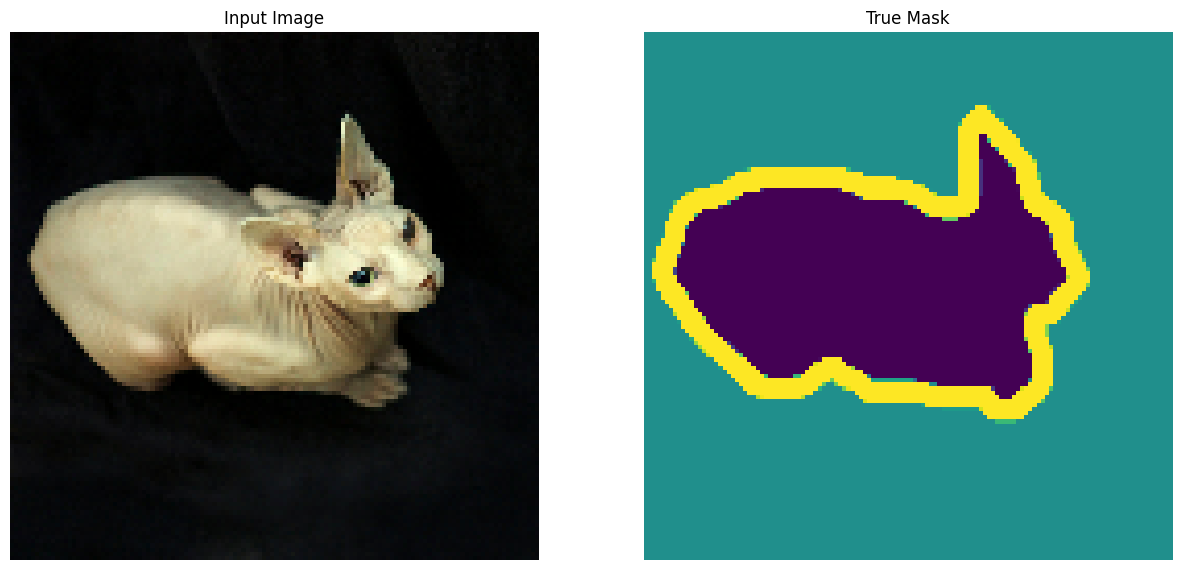

In [7]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [8]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,3], include_top=False)

In [9]:
layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project',
]
layers = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512,3),
    pix2pix.upsample(256,3),
    pix2pix.upsample(128,3),
    pix2pix.upsample(64,3),
]

In [10]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128,128,3])
    
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
    
    last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, padding='same')
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [11]:
OUTPUT_CHANNELS = 3
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [13]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step


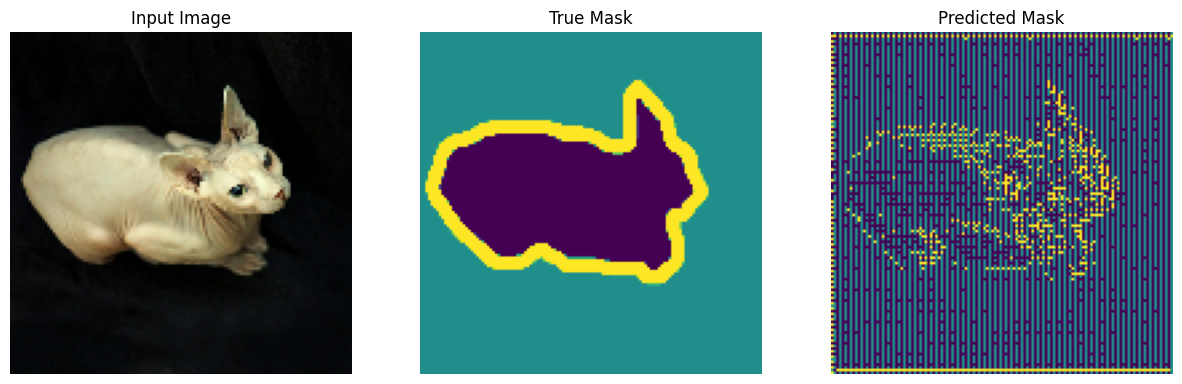

In [14]:
show_predictions()

In [15]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print(f" \nSample Prediction after epoch {epoch+1} \n")

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

Epoch 1/20


In [1]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'bo', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.ylim([0,1])
plt.legend()
plt.show()

NameError: name 'model_history' is not defined